# Online linear regression with Kalman filter

In [8]:
import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt
from functools import partial
from rebayes_mini import callbacks
from rebayes_mini.methods import kalman_filter as kf

In [2]:
%load_ext autoreload
%autoreload 2
%config InlineBackend.figure_format = "retina"

In [3]:
plt.style.use('dark_background')

acolors = [
    "#D9117F",
    "#0DD9D9",
    "#F2A30F",
    "#F26E22",
]

colors = list(v["color"] for v in plt.rcParams["axes.prop_cycle"])

plt.rcParams["axes.spines.right"] = False
plt.rcParams["axes.spines.top"] = False

## Dataset

In [4]:
key = jax.random.PRNGKey(314)
key_err, key_shuffle = jax.random.split(key)

n_samples = 200
x = jnp.linspace(-3, 3, n_samples)
errs = jax.random.normal(key, (n_samples,))
yclean = 1 + 2 * x
y = yclean + errs

ixs = jax.random.choice(key_shuffle, n_samples, (n_samples,), replace=False)
D = jnp.c_[x, y][ixs]
x, y = D[:, 0], D[:, 1]

X = jnp.c_[jnp.ones(n_samples), x]

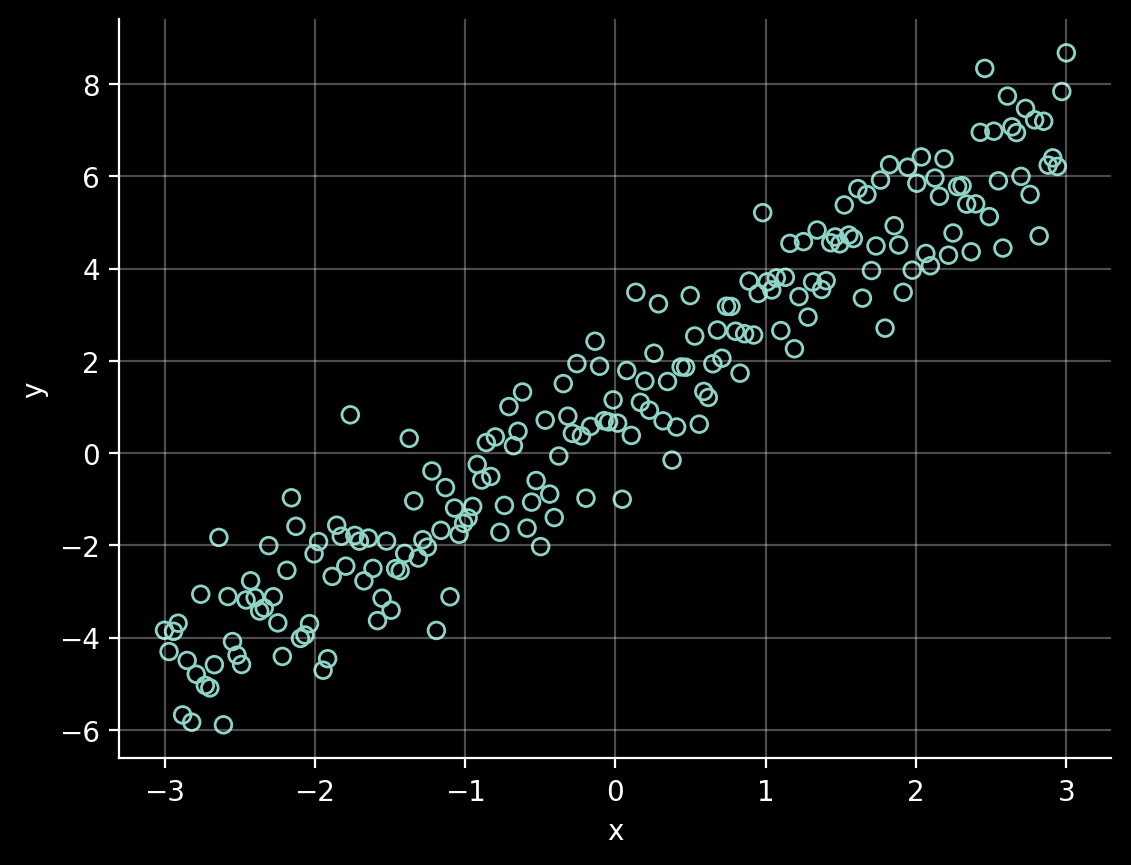

In [5]:
plt.scatter(x, y, edgecolors=colors[0], color="none")
plt.xlabel("x")
plt.ylabel("y")
plt.grid(alpha=0.3)

In [9]:
alpha = 1.0
theta_map = jnp.linalg.inv(X.T @ X + alpha * jnp.eye(2)) @ X.T @ y
theta_map

Array([1.0858634, 1.9981399], dtype=float32)

In [16]:
def link(w, x):
    return (w @ x)[None]

agent = kf.GaussianFilter(link, 0.0)
w0 = jnp.zeros((2,))
bel_init = agent.init_bel(w0, cov=1.0)
bel, hist = agent.scan(bel_init, y, X, callbacks.get_updated_mean)

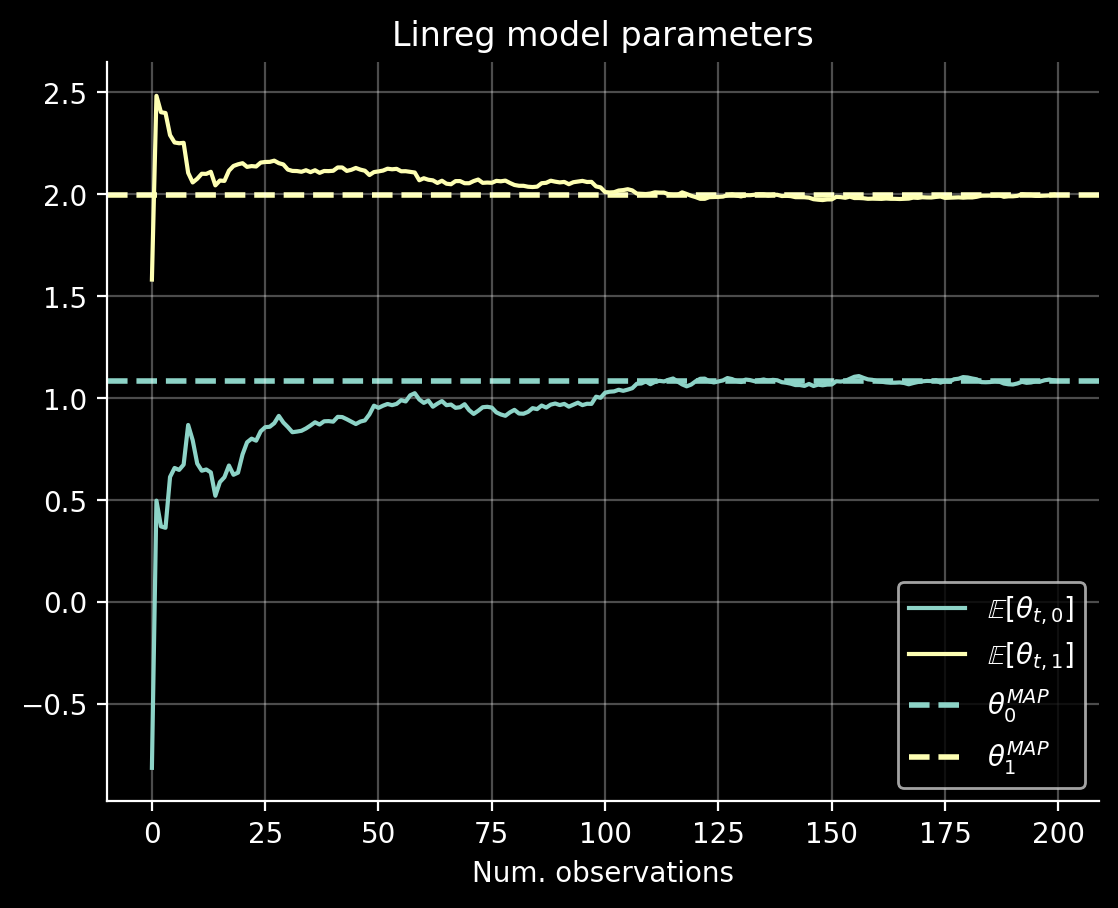

In [19]:
plt.plot(hist[:, 0], label=r"$\mathbb{E}[\theta_{t,0}]$")
plt.plot(hist[:, 1], label=r"$\mathbb{E}[\theta_{t,1}]$")

plt.axhline(theta_map[0], linestyle="--", c=colors[0], linewidth=2, zorder=0, label=r"$\theta_0^{MAP}$")
plt.axhline(theta_map[1], linestyle="--", c=colors[1], linewidth=2, zorder=0, label=r"$\theta_1^{MAP}$")
plt.xlabel("Num. observations")
plt.legend()
plt.title("Linreg model parameters")
plt.grid(alpha=0.3)

## yhat

In [20]:
yhat = jax.vmap(agent.link_fn, (None, 0))(bel.mean, X)

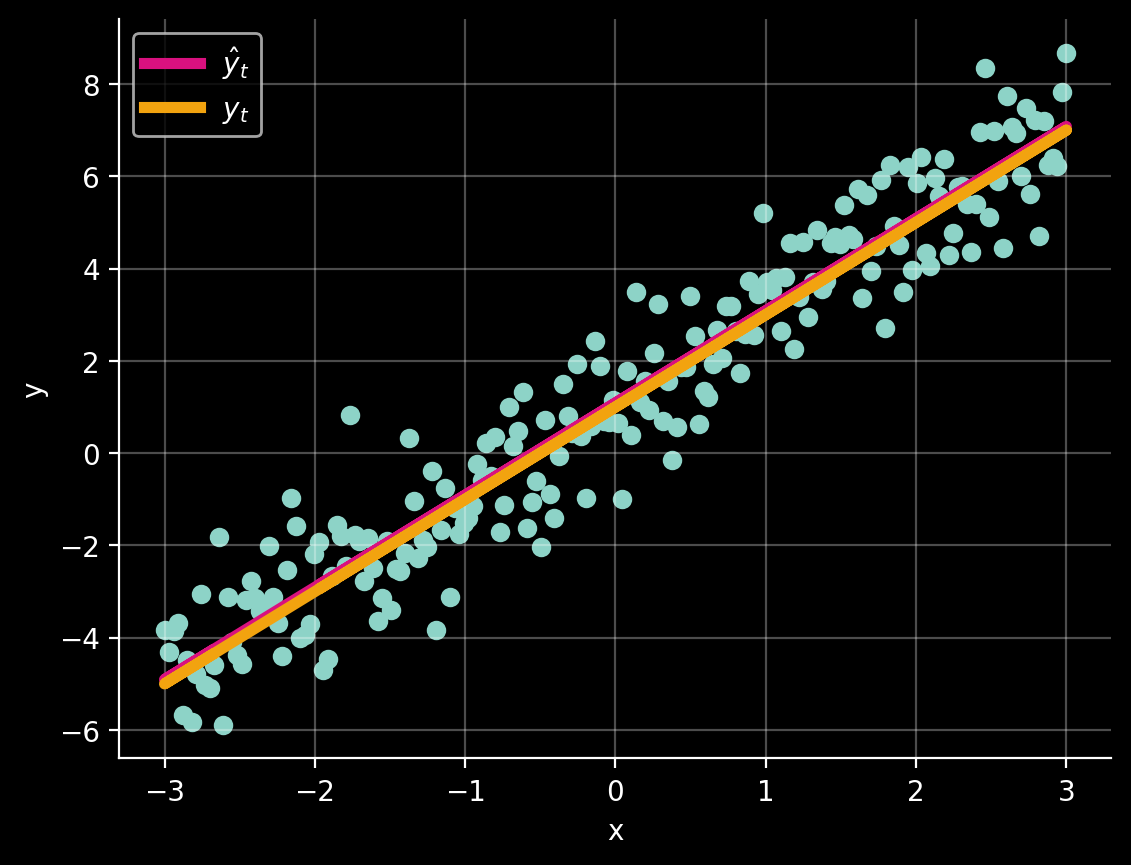

In [21]:
plt.scatter(x, y)
plt.plot(x, yhat, c=acolors[0], linewidth=4, label=r"$\hat{y}_t$")
plt.plot(x, 2 * x + 1, c=acolors[2], linewidth=4, label="$y_t$")
plt.legend()
plt.xlabel("x")
plt.ylabel("y")
plt.grid(alpha=0.3)